## **Task**

Here we have some data about health insurance. Stakeholders provide us data with task of analysis and predictive modeling of charges based on provided features.

In this notebook we will try to apply regression analysis to our dataset. We will apply various regression technics to perform best at our data. But before that we will explore our features with: Correlation Matrix, Principal Component Analysis, Decision Trees feature importance and Permutation importance technics.

This dataset was founded on Kaggle. [dataset online](https://www.kaggle.com/datasets/mirichoi0218/insurance)

In [ ]:
# some imports of packages needed
# for data exploration and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load statistical packages
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# sklearn packages
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# first things first: let's get our data and look and it.
data_path = "/content/drive/MyDrive/Data Analyst Pet Project/Data/prepared_data.csv"

df = pd.read_csv(data_path)

df.head(5)

,age,children,sex,smoker,region,bmi,charges
0,19.0,0.0,0.0,1.0,3.0,0.321227,0.251611
1,18.0,1.0,1.0,0.0,2.0,0.479150,0.009636
2,28.0,3.0,1.0,0.0,2.0,0.458434,0.053115
3,33.0,0.0,1.0,0.0,1.0,0.181464,0.333010
4,32.0,0.0,1.0,0.0,1.0,0.347592,0.043816


## **Data Exploration with statistics and PCA**

Lets again look at our features in a big picture.

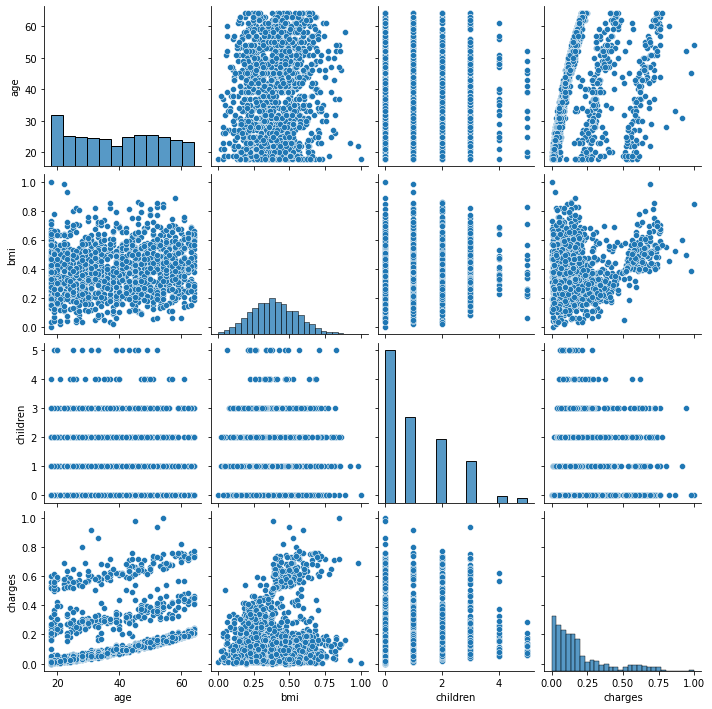

In [ ]:
sns.pairplot(df[['age', 'bmi', 'children', 'charges']])
plt.show()

Data is the same, let's move on to correlation matrix.

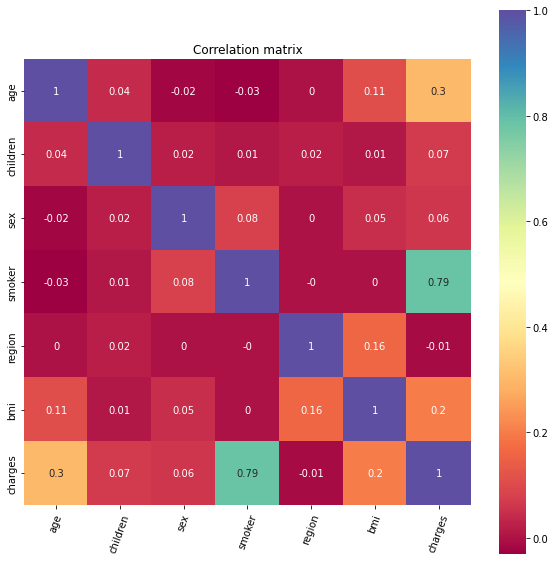

In [ ]:
corr = df.corr().round(2)
plt.figure(figsize=(10, 10))
plt.title('Correlation matrix')
sns.heatmap(corr, square=True, cmap='Spectral', annot=True)
plt.xticks(rotation=70)
plt.show()

All features are pretty not correlated, except for `smoker` and `charges` that show high linear relation. Even our matrix is overall close to zero, we will check data for any multicolinearity with Variance Influence Factor (VIF).

In [ ]:
# compute the vif for all given features
# we specify columns param, because if needed
# we should perform VIF analysis multiple times
# with different columns
def compute_vif(df, columns):
    # select features and add constant column
    X = df[columns].assign(const=1)
    # the calculation of variance inflation requires a constant
    vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                    index=X.columns).sort_values(ascending=False)
    return vif.to_frame(name='VIF')

In [ ]:
compute_vif(df, ['age', 'children', 'sex', 'smoker', 'region', 'bmi'])

,VIF
const,16.104273
bmi,1.040608
region,1.025966
age,1.015394
sex,1.008889
smoker,1.006466
children,1.002482


As we see from those scores there are completly no multicolinearity in our data, in general we remove features with VIF bigger than 5, but here is everything is OK.

Moving on, lets perform PCA to analyze amount of information in each feature.

In [ ]:
def principal_component_analysis(df):
    X = df.copy()
    # Applying principal component analysis
    pca_ = PCA()
    pca_.fit(X)

    # retrieve eigen values
    n_pcs = pca_.components_.shape[0]
    # We are looking for 'longest' vector which indicates most
    # important feature
    most_important = [np.abs(pca_.components_[i]).argmax() for i in range(n_pcs)]
    # get names of most important features
    cols = df.columns
    most_important_names = [cols[most_important[i]] for i in range(n_pcs)]
    print('Two most informative factors:\n',
          most_important_names[:2])
    print('-'*25)

    # Візуалізація буде включати критерій
    # кам'янистого осипу та вклад в дисперсію
    fig, ax = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)
    ax[0].plot(range(1, len(pca_.explained_variance_)+1),
               pca_.explained_variance_,
               color='blue', lw=4)
    ax[0].scatter(x=range(1, len(pca_.explained_variance_)+1),
                  y=pca_.explained_variance_,
                  linewidths=6,
                  color='blue',
                  marker="v",
                  s=3)
    ax[0].set_title("Elbow plot to select number of features")
    ax[0].set_xlabel('Component number')
    ax[0].set_ylabel('Eigen values')

    ax[1].plot(range(1, len(pca_.explained_variance_ratio_)+1),
               pca_.explained_variance_ratio_.cumsum(),
               color='red', lw=4)
    ax[1].scatter(x=range(1, len(pca_.explained_variance_ratio_)+1),
                  y=pca_.explained_variance_ratio_.cumsum(),
                  linewidths=6,
                  color='red',
                  marker="v",
                  s=3)
    ax[1].axhline(0.6 ,color='black', linewidth=0.5, linestyle='dashdot')
    ax[1].annotate(f"level : {60}%", 
            xy=(n_pcs-0.5, 0.57),
            va='center',
            ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    
    ax[1].axhline(0.8 ,color='black', linewidth=0.5, linestyle='dashdot')
    ax[1].annotate(f"level : {80}%", 
            xy=(n_pcs-0.5, 0.77),
            va='center',
            ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    
    ax[1].axhline(0.9 ,color='black', linewidth=0.5, linestyle='dashdot')
    ax[1].annotate(f"level : {90}%", 
            xy=(n_pcs-0.5, 0.87),
            va='center',
            ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    ax[1].axhline(0.98 ,color='black', linewidth=0.5, linestyle='dashdot')
    ax[1].annotate(f"level : {98}%", 
            xy=(n_pcs-0.5, 0.95),
            va='center',
            ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))

    ax[1].set_title("Contribution to Variance")
    ax[1].set_xlabel('number of components')
    ax[1].set_ylabel('contribution to variance in percents')
    if pca_.explained_variance_ratio_.cumsum()[0] < 0.4:
        ax[1].set_ylim(0.0, 1.1)
    else:    
        ax[1].set_ylim(0.4, 1.1)
    plt.show()

Two most informative factors:
 ['age', 'children']
-------------------------


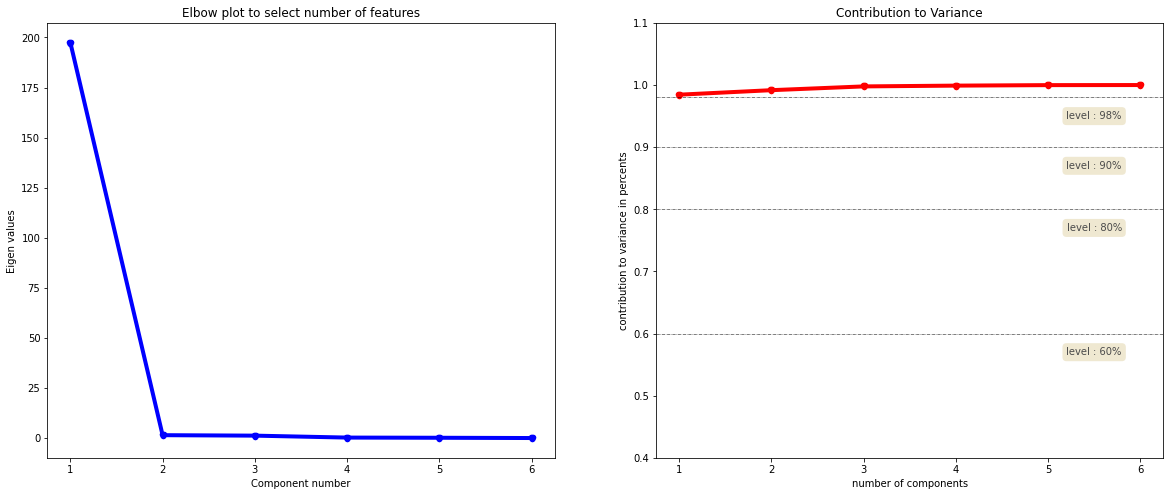

In [ ]:
principal_component_analysis(df[['age', 'children', 'sex', 'smoker', 'region', 'bmi']])

We see that PCA yields 2 components, that means, if needed we can compres our dataset to two variables. And to explain 98% of variance we can leave only one feature in our dataset, and that feature is client's age.

## **Regression Analysis**

And now we are heading to regression analysis. This will consist of several steps.


1.   _Linear regression analysis_


> * Transform dependent variable to normal distribution.
> * Perform regression modeling and check p-values, adequacy and distribution of residuals.
> * If everything is ok, perform K-Fold cross validation to ensure performance on different dataset parts.
> * Use permutation feature importance process to identify feature importance.

2.   _Decision trees regression_

> * Transform dependent variable to normal distribution.
> * Apply random forest algorithm.
> * Check feature importance produced by algorithm.
> * Apply K-Fold cross validation and permutation feature importance process.



### Linear Regression Analysis

First thing first, let's split our data into train and test sets.

In [ ]:
X = df[['age', 'children', 'sex', 'smoker', 'region', 'bmi']]
y = df['charges'].values
# apply train-test split for our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Lets apply Quantile Transformer to make our target variable looks more Gaussian

In [ ]:
# define quantile transformer
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
# transform data
y_train_transformed = qt.fit_transform(y_train.reshape(-1, 1))
y_test_transformed = qt.transform(y_test.reshape(-1, 1))

In [ ]:
# apply lenear regressio
X_train_const = sm.add_constant(X_train)

lreg = sm.OLS(y_train_transformed, X_train_const).fit()
predictions = lreg.predict(X_train_const) 

print_model = lreg.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     529.0
Date:                Thu, 25 Aug 2022   Prob (F-statistic):          5.39e-315
Time:                        13:52:08   Log-Likelihood:                -798.12
No. Observations:                1070   AIC:                             1610.
Df Residuals:                    1063   BIC:                             1645.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0524      0.063    -32.633      0.0

Since we transformed our data to Gaussian distribution, all coefficients are significant, residuals are normaly distributed and model is adequate. By using simple measure, we see by the $R^2$ that it is 0.749, which roughly means that our model is 75% accurate.

Lets apply model to the test set.

In [ ]:
r2_test = r2_score(y_test_transformed, lreg.predict(sm.add_constant(X_test)))
print('R-squared test:', r2_test)
mse_test = mean_squared_error(y_test_transformed, lreg.predict(sm.add_constant(X_test)))
print('MSE test:', mse_test)

R-squared test: 0.7850982705870517
MSE test: 0.2456358083486598


By this two metrics we can see that model corectly predict values for test set too.

Lets now apply K-Fold cross validation to see how model performs in different parts of dataset

In [ ]:
# define K-Fold
kf = KFold(n_splits=5)
i = 1

# Apply K-Fold index selection for dataset
for train_index, test_index in kf.split(X):

    if i > 1:
        print('\n\n')
    
    print("*"*78 + f"\nFold {i}\n" + "*"*78)
    # select data by K-Fold index
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # define quantile transformer
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
    # transform data
    y_train_transformed = qt.fit_transform(y_train.reshape(-1, 1))
    y_test_transformed = qt.transform(y_test.reshape(-1, 1))
    # apply lenear regressio
    X_train_const = sm.add_constant(X_train)
    # Apply linear regression
    lreg = sm.OLS(y_train_transformed, X_train_const).fit()
    predictions = lreg.predict(X_train_const) 
    # print regression summary
    print_model = lreg.summary()
    print(print_model)
    # check regresison metrics
    r2_test = r2_score(y_test_transformed, lreg.predict(sm.add_constant(X_test)))
    print('\nR-squared test:', r2_test)
    mse_test = mean_squared_error(y_test_transformed, lreg.predict(sm.add_constant(X_test)))
    print('MSE test:', mse_test)

    i += 1

******************************************************************************
Fold 1
******************************************************************************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     535.7
Date:                Thu, 25 Aug 2022   Prob (F-statistic):          3.47e-317
Time:                        13:52:08   Log-Likelihood:                -793.10
No. Observations:                1070   AIC:                             1600.
Df Residuals:                    1063   BIC:                             1635.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t  

As we see linear model yields pretty stable results across 5 variants od dataset splits, this model seems to be pretty good for this dataset.

And lastly, lets use permutation feature importance feature for linear regression.<br><br>
But for now, since we already now that linear model is statisticaly good choice, we will use `sklearn` API just for the matter of simplicity.

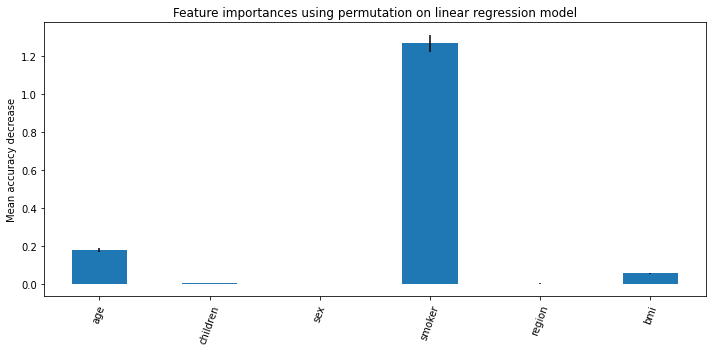

In [ ]:
# remind ourselfs about X and y
x_cols = ['age', 'children', 'sex', 'smoker', 'region', 'bmi']
X = df[x_cols]
y = df['charges'].values
# define transformer
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
# transform data
y_transformed = qt.fit_transform(y.reshape(-1, 1))
# apply linear regression
lreg = LinearRegression().fit(X, y)
# apply process of finding feature importance
result = permutation_importance(lreg, X, y, n_repeats=10,
                                random_state=42)

importances = pd.Series(result.importances_mean, index=x_cols)

fig, ax = plt.subplots(figsize=(10, 5))
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on linear regression model")
ax.set_ylabel("Mean accuracy decrease")
ax.set_xticklabels(x_cols, rotation=70)
fig.tight_layout()
plt.show()

By using permutation feature importances we see that the most impact on predictions are produced by `smoker`, `age` and `bmi` fatures respectively. But `smoker` attribute has the most influence. 

### Decision Trees Regression

firstly we split our data

In [ ]:
X = df[['age', 'children', 'sex', 'smoker', 'region', 'bmi']]
y = df['charges'].values
# apply train-test split for our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

then transform it to Gaussian distribution

In [ ]:
# define quantile transformer
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
# transform data
y_train_transformed = qt.fit_transform(y_train.reshape(-1, 1))
y_test_transformed = qt.transform(y_test.reshape(-1, 1))

Specify regressor estimator

In [ ]:
regr = RandomForestRegressor(n_estimators=500, max_depth=5,
                             min_samples_split=5, random_state=42)
regr.fit(X_train, y_train_transformed)

RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=500,
                      random_state=42)

Evaluate at train set

In [ ]:
r2_train = r2_score(y_train_transformed, regr.predict(X_train))
print('R-squared train:', r2_train)
mse_train = mean_squared_error(y_train_transformed, regr.predict(X_train))
print('MSE test:', mse_train)

R-squared train: 0.851632001986395
MSE test: 0.15390655824114988


Evaluate at test set

In [ ]:
r2_test = r2_score(y_test_transformed, regr.predict(X_test))
print('R-squared test:', r2_test)
mse_test = mean_squared_error(y_test_transformed, regr.predict(X_test))
print('MSE test:', mse_test)

R-squared test: 0.8395000247720201
MSE test: 0.18345381055220716


As we see, results are much better than for linear regression model. Personally, I consider that results are somewhat good if $R^2$ is superior than 0.6, and what we got here is pretty decent score.

Lets evaluate our model with K-Fold cross validation

In [ ]:
# define K-Fold
kf = KFold(n_splits=3)
i = 1

# Apply K-Fold index selection for dataset
for train_index, test_index in kf.split(X):

    if i > 1:
        print('\n\n')
    
    print("*"*78 + f"\nFold {i}\n" + "*"*78)
    # select data by K-Fold index
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # define quantile transformer
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
    # transform data
    y_train_transformed = qt.fit_transform(y_train.reshape(-1, 1))
    y_test_transformed = qt.transform(y_test.reshape(-1, 1))
    
    regr = RandomForestRegressor(n_estimators=500, max_depth=5,
                                 min_samples_split=5, random_state=42)
    regr.fit(X_train, y_train_transformed)

    r2_train = r2_score(y_train_transformed, regr.predict(X_train))
    print('R-squared train:', r2_train)
    mse_train = mean_squared_error(y_train_transformed, regr.predict(X_train))
    print('MSE test:', mse_train)

    r2_test = r2_score(y_test_transformed, regr.predict(X_test))
    print('R-squared test:', r2_test)
    mse_test = mean_squared_error(y_test_transformed, regr.predict(X_test))
    print('MSE test:', mse_test)
    i += 1

******************************************************************************
Fold 1
******************************************************************************
R-squared train: 0.8692601269018276
MSE test: 0.13664938644902302
R-squared test: 0.8247360098065869
MSE test: 0.18026254517301082



******************************************************************************
Fold 2
******************************************************************************
R-squared train: 0.8495707982685811
MSE test: 0.15722868344211455
R-squared test: 0.8445640559602806
MSE test: 0.17166042664861933



******************************************************************************
Fold 3
******************************************************************************
R-squared train: 0.8676289015811351
MSE test: 0.13835428236691943
R-squared test: 0.7709183548378155
MSE test: 0.22597692514513779


Results for test set display pretty high variance

One of the strong sides of trees, that they have their algorithm inside to define feature importance, so we will explore this values here.

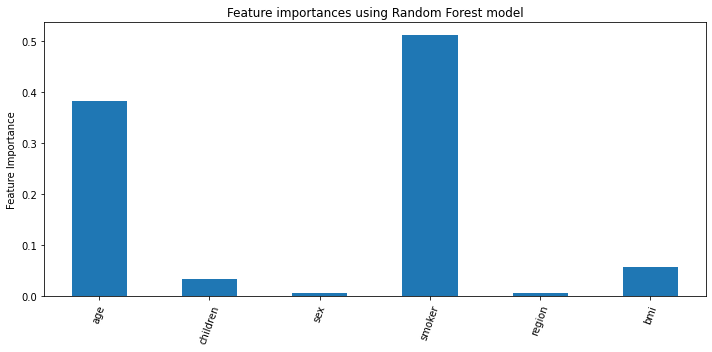

In [ ]:
# remind ourselfs about X and y
x_cols = ['age', 'children', 'sex', 'smoker', 'region', 'bmi']
X = df[x_cols]
y = df['charges'].values
# define transformer
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
# transform data
y_transformed = qt.fit_transform(y.reshape(-1, 1))
# apply linear regression
regr = RandomForestRegressor(n_estimators=500, max_depth=5,
                             min_samples_split=5, random_state=42).fit(X, y_transformed)

importances = pd.Series(regr.feature_importances_, index=x_cols)

fig, ax = plt.subplots(figsize=(10, 5))
importances.plot.bar(ax=ax)
ax.set_title("Feature importances using Random Forest model")
ax.set_ylabel("Feature Importance")
ax.set_xticklabels(x_cols, rotation=70)
fig.tight_layout()
plt.show()

We see a bit different picture comparing with linear regression, but three most important features are pretty the same.

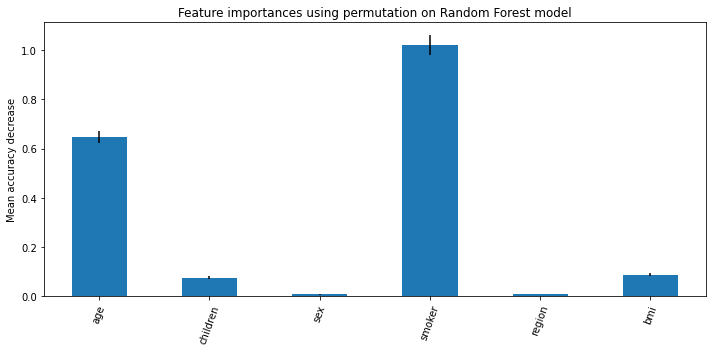

In [ ]:
# remind ourselfs about X and y
x_cols = ['age', 'children', 'sex', 'smoker', 'region', 'bmi']
X = df[x_cols]
y = df['charges'].values
# define transformer
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
# transform data
y_transformed = qt.fit_transform(y.reshape(-1, 1))
# apply linear regression
regr = RandomForestRegressor(n_estimators=500, max_depth=5,
                             min_samples_split=5, random_state=42).fit(X, y_transformed)
# apply process of finding feature importance
result = permutation_importance(regr, X, y_transformed, n_repeats=10,
                                random_state=42)

importances = pd.Series(result.importances_mean, index=x_cols)

fig, ax = plt.subplots(figsize=(10, 5))
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on Random Forest model")
ax.set_ylabel("Mean accuracy decrease")
ax.set_xticklabels(x_cols, rotation=70)
fig.tight_layout()
plt.show()

And again we see that `smoker`, `age` and `bmi` respectively three most important features in this dataset.